In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
# Reading in graph 
G = nx.read_weighted_edgelist("data/yeast.txt",comments="#",nodetype=str)

In [3]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
  weight = list(G.get_edge_data(edge[0],edge[1]).values())
  if(weight[0] <= threshold_score):
    G.remove_edge(edge[0],edge[1])

G = nx.relabel_nodes(G, lambda x: x[5:])

In [4]:
# Consider only the giant component
GC = G.subgraph(max(nx.connected_components(G), key=len)).copy()

In [5]:
# Getting list of all yeast homologs
df = pd.read_csv("data/human_to_yeast.csv")

# Note: some homologs in this list may also be present in the essential nodes list, so they wont be included in the subgraph.
homologs = list(set(list(df["homolog_systematic_name"])))

In [6]:
# Getting subgraph induced by all yeast homologs
NAFLD = GC.subgraph(homologs).copy()
NAFLD_isolated = list(nx.isolates(NAFLD))
print(NAFLD_isolated)

['YLL055W', 'YGL159W', 'YJR085C', 'YPR131C', 'YGR065C', 'YDR371W', 'YBR046C', 'YLR004C', 'YBL057C', 'YDR338C', 'YCR026C', 'YOL119C', 'YLR001C', 'YDL219W', 'YDR372C', 'YBR104W', 'YHR078W', 'YDR105C', 'YJR126C', 'YJL079C', 'YDR221W', 'YOR256C', 'YJR100C', 'YER140W', 'YML087C', 'YOR093C', 'YBR210W', 'YKL198C', 'YLL048C', 'YKR013W', 'YGL096W', 'YMR212C', 'YML125C', 'YBR233W', 'YPR058W', 'YPL088W', 'YDR236C', 'YDR151C', 'YLL061W', 'YAL067C', 'YCR075C', 'YCR028C-A', 'YOR280C', 'YER159C', 'YCR028C', 'YJR001W']


We see that there are many NAFLD nodes which are isolated from the other NAFLD nodes. We aim to find good candidate nodes for linking all NAFLD nodes together in a tree. 

In [7]:
# Create separate graph where all edge weights are 1
GC1 = GC.copy()
for (u, v, d) in GC1.edges().data():
  d['weight'] = 1

In [8]:
# Obtain list of all NAFLD nodes present in GC1
NAFLD_nodes = []
for node in GC1.nodes():
  if node in homologs:
    NAFLD_nodes.append(node)

In [9]:
import stp

node_to_int = stp.nxgraph_to_stp(graph=GC1, terminals=NAFLD_nodes, filename="NAFLD.stp")

We then use the NAFLD.stp file and SCIP-Jack to solve the STP. This returns a NAFLD.stp_logfi

In [23]:
int_to_node = {v: k for k, v in node_to_int.items()}

ST = stp.stplog_to_nxgraph(filename="NAFLD.stplog", int_to_node=int_to_node)

Now, we remove all the NAFLD nodes to leave us with the non-NAFLD nodes for analysis. These nodes are regarded as the "intermediate nodes" that are connecting all our NAFLD nodes to each other.

In [39]:
non_NAFLD = []
for node in ST.nodes():
  if node not in NAFLD_nodes:
    non_NAFLD.append(node)

In [48]:
node_color = []
node_size = []
for node in ST.nodes():
  if node in non_NAFLD:
    node_color.append("red")
    node_size.append(20)
  else:
    node_color.append("black")
    node_size.append(1)

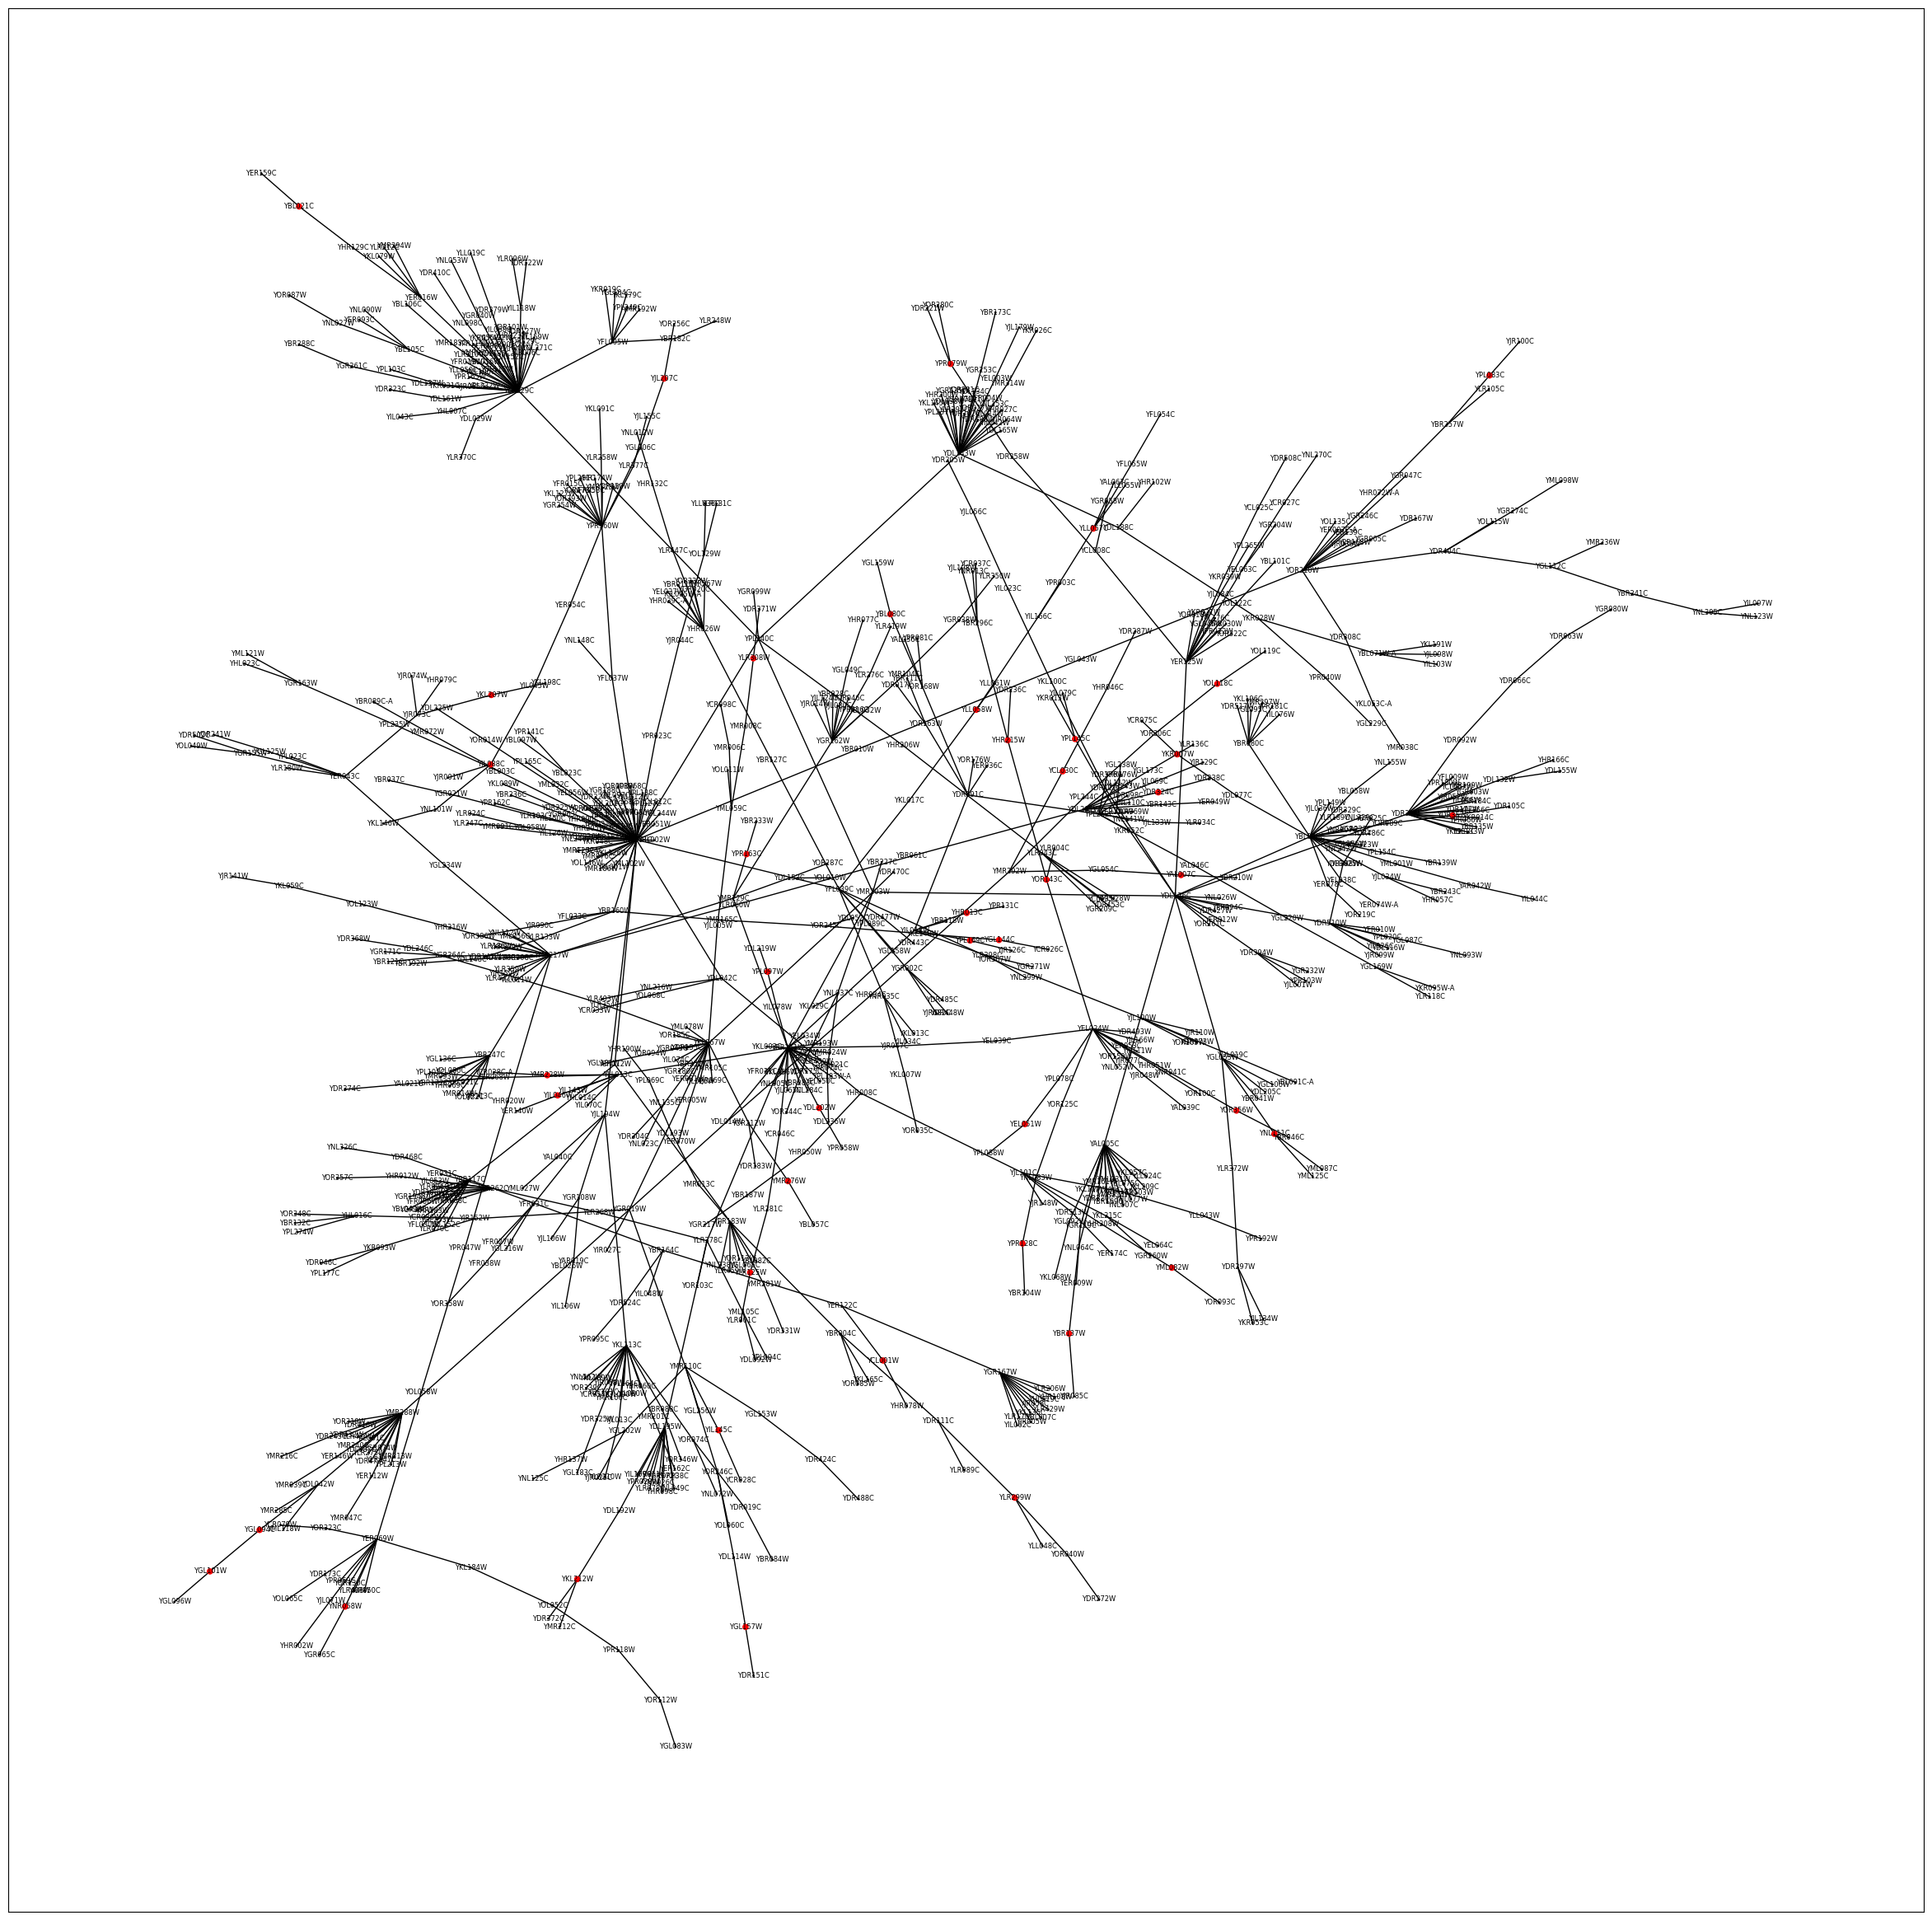

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
nx.draw_networkx(ST, with_labels=True, font_size=6, node_color=node_color, node_size=node_size)
plt.show()

From here, we aim to narrow down this list of intermediate nodes to some quality candidate nodes for experiments. We first check if any of the candidate nodes are essential before analysing them further.

In [55]:
candidates = non_NAFLD.copy()

df = pd.read_csv("data/essential_proteins.csv", header=None)
essential_proteins = df[1].values

essential_candidates = [node for node in candidates if node in essential_proteins]
print(essential_candidates)

['YKL212W', 'YMR276W', 'YPL169C', 'YPL083C', 'YDR324C', 'YOR143C']


Degree Centrality

In [78]:
ST_degrees = [(node, ST.degree(node)) for node in non_NAFLD]
print(sorted(ST_degrees, reverse=True, key=lambda x: x[1]))

ST_degrees = [(node, ST.degree(node)) for node in non_NAFLD]
print(sorted(ST_degrees, reverse=True, key=lambda x: x[1]))

[('YLL057C', 4), ('YNL111C', 3), ('YKL212W', 3), ('YPL145C', 3), ('YPR079W', 3), ('YLR299W', 3), ('YLL058W', 3), ('YHR215W', 3), ('YOR143C', 3), ('YIL088C', 3), ('YDL202W', 2), ('YBL080C', 2), ('YMR228W', 2), ('YPL097W', 2), ('YJL046W', 2), ('YHR013C', 2), ('YEL051W', 2), ('YOR356W', 2), ('YCL030C', 2), ('YNR058W', 2), ('YDR357C', 2), ('YJL207C', 2), ('YPR163C', 2), ('YMR276W', 2), ('YBR137W', 2), ('YBL021C', 2), ('YPL169C', 2), ('YAL007C', 2), ('YCL001W', 2), ('YPL083C', 2), ('YKL207W', 2), ('YML082W', 2), ('YIL145C', 2), ('YKR007W', 2), ('YGL094C', 2), ('YGL157W', 2), ('YLR308W', 2), ('YDR324C', 2), ('YLR125W', 2), ('YPR128C', 2), ('YGL144C', 2), ('YGL101W', 2), ('YOL118C', 2)]
[('YLL057C', 4), ('YNL111C', 3), ('YKL212W', 3), ('YPL145C', 3), ('YPR079W', 3), ('YLR299W', 3), ('YLL058W', 3), ('YHR215W', 3), ('YOR143C', 3), ('YIL088C', 3), ('YDL202W', 2), ('YBL080C', 2), ('YMR228W', 2), ('YPL097W', 2), ('YJL046W', 2), ('YHR013C', 2), ('YEL051W', 2), ('YOR356W', 2), ('YCL030C', 2), ('YNR0

In [53]:
GC1_degrees = [(node, GC1.degree(node)) for node in non_NAFLD]
print(sorted(GC1_degrees, reverse=True, key=lambda x: x[1]))

[('YDR324C', 231), ('YPL169C', 172), ('YDL202W', 163), ('YPR163C', 98), ('YCL030C', 65), ('YMR276W', 65), ('YHR013C', 64), ('YPL097W', 55), ('YKL212W', 48), ('YEL051W', 47), ('YML082W', 33), ('YLL058W', 29), ('YLR299W', 28), ('YBL080C', 26), ('YCL001W', 26), ('YKR007W', 26), ('YOR143C', 25), ('YHR215W', 22), ('YPL083C', 21), ('YJL046W', 20), ('YOR356W', 20), ('YIL145C', 20), ('YNL111C', 19), ('YPR128C', 19), ('YAL007C', 16), ('YKL207W', 16), ('YPL145C', 15), ('YGL094C', 15), ('YNR058W', 13), ('YJL207C', 13), ('YGL144C', 13), ('YBR137W', 12), ('YPR079W', 12), ('YLL057C', 11), ('YBL021C', 10), ('YLR125W', 10), ('YOL118C', 10), ('YDR357C', 9), ('YLR308W', 9), ('YGL157W', 8), ('YIL088C', 6), ('YGL101W', 5), ('YMR228W', 4)]


Betweenness Centrality

In [72]:
ST_bc = [(node, round(bc, 4)) for (node, bc) in list(nx.centrality.betweenness_centrality(ST).items()) if node in non_NAFLD]
print(sorted(ST_bc, reverse=True, key=lambda x: x[1]))

[('YLL058W', 0.0177), ('YOR143C', 0.0155), ('YHR215W', 0.0111), ('YLL057C', 0.0089), ('YLR299W', 0.0067), ('YIL088C', 0.0067), ('YCL030C', 0.0044), ('YNL111C', 0.0044), ('YKL212W', 0.0044), ('YPL145C', 0.0044), ('YPR079W', 0.0044), ('YGL094C', 0.0044), ('YDL202W', 0.0022), ('YBL080C', 0.0022), ('YMR228W', 0.0022), ('YPL097W', 0.0022), ('YJL046W', 0.0022), ('YHR013C', 0.0022), ('YEL051W', 0.0022), ('YOR356W', 0.0022), ('YNR058W', 0.0022), ('YDR357C', 0.0022), ('YJL207C', 0.0022), ('YPR163C', 0.0022), ('YMR276W', 0.0022), ('YBR137W', 0.0022), ('YBL021C', 0.0022), ('YPL169C', 0.0022), ('YAL007C', 0.0022), ('YCL001W', 0.0022), ('YPL083C', 0.0022), ('YKL207W', 0.0022), ('YML082W', 0.0022), ('YIL145C', 0.0022), ('YKR007W', 0.0022), ('YGL157W', 0.0022), ('YLR308W', 0.0022), ('YDR324C', 0.0022), ('YLR125W', 0.0022), ('YPR128C', 0.0022), ('YGL144C', 0.0022), ('YGL101W', 0.0022), ('YOL118C', 0.0022)]


In [73]:
GC1_bc = [(node, round(bc, 4)) for (node, bc) in list(nx.centrality.betweenness_centrality(GC1, k=100).items()) if node in non_NAFLD]
print(sorted(GC1_bc, reverse=True, key=lambda x: x[1]))

[('YPL169C', 0.0046), ('YLR308W', 0.0015), ('YCL030C', 0.0014), ('YMR276W', 0.0014), ('YOR143C', 0.0014), ('YKL212W', 0.0012), ('YBL080C', 0.0008), ('YEL051W', 0.0007), ('YNL111C', 0.0007), ('YML082W', 0.0007), ('YDL202W', 0.0006), ('YKL207W', 0.0006), ('YPL145C', 0.0005), ('YDR324C', 0.0005), ('YGL144C', 0.0005), ('YLR299W', 0.0004), ('YIL145C', 0.0004), ('YKR007W', 0.0004), ('YPL097W', 0.0003), ('YJL046W', 0.0003), ('YJL207C', 0.0003), ('YPR163C', 0.0003), ('YBL021C', 0.0003), ('YLL058W', 0.0003), ('YOL118C', 0.0003), ('YHR013C', 0.0002), ('YNR058W', 0.0002), ('YBR137W', 0.0002), ('YCL001W', 0.0002), ('YGL094C', 0.0002), ('YPR128C', 0.0002), ('YIL088C', 0.0002), ('YGL101W', 0.0002), ('YOR356W', 0.0001), ('YPR079W', 0.0001), ('YPL083C', 0.0001), ('YGL157W', 0.0001), ('YLL057C', 0.0001), ('YHR215W', 0.0001), ('YLR125W', 0.0001), ('YMR228W', 0.0), ('YDR357C', 0.0), ('YAL007C', 0.0)]


Eigenvector Centrality

In [74]:
ST_eigen = [(node, round(eigen, 4)) for (node, eigen) in list(nx.centrality.eigenvector_centrality(ST).items()) if node in non_NAFLD]
print(sorted(ST_bc, reverse=True, key=lambda x: x[1]))

[('YLL058W', 0.0177), ('YOR143C', 0.0155), ('YHR215W', 0.0111), ('YLL057C', 0.0089), ('YLR299W', 0.0067), ('YIL088C', 0.0067), ('YCL030C', 0.0044), ('YNL111C', 0.0044), ('YKL212W', 0.0044), ('YPL145C', 0.0044), ('YPR079W', 0.0044), ('YGL094C', 0.0044), ('YDL202W', 0.0022), ('YBL080C', 0.0022), ('YMR228W', 0.0022), ('YPL097W', 0.0022), ('YJL046W', 0.0022), ('YHR013C', 0.0022), ('YEL051W', 0.0022), ('YOR356W', 0.0022), ('YNR058W', 0.0022), ('YDR357C', 0.0022), ('YJL207C', 0.0022), ('YPR163C', 0.0022), ('YMR276W', 0.0022), ('YBR137W', 0.0022), ('YBL021C', 0.0022), ('YPL169C', 0.0022), ('YAL007C', 0.0022), ('YCL001W', 0.0022), ('YPL083C', 0.0022), ('YKL207W', 0.0022), ('YML082W', 0.0022), ('YIL145C', 0.0022), ('YKR007W', 0.0022), ('YGL157W', 0.0022), ('YLR308W', 0.0022), ('YDR324C', 0.0022), ('YLR125W', 0.0022), ('YPR128C', 0.0022), ('YGL144C', 0.0022), ('YGL101W', 0.0022), ('YOL118C', 0.0022)]


In [75]:
GC1_bc = [(node, round(eigen, 4)) for (node, eigen) in list(nx.centrality.eigenvector_centrality(GC1).items()) if node in non_NAFLD]
print(sorted(GC1_bc, reverse=True, key=lambda x: x[1]))

[('YDR324C', 0.0465), ('YDL202W', 0.0342), ('YPL169C', 0.0221), ('YPR163C', 0.0158), ('YHR013C', 0.0151), ('YMR276W', 0.0014), ('YPL097W', 0.0011), ('YCL030C', 0.0006), ('YPL083C', 0.0006), ('YGL144C', 0.0006), ('YEL051W', 0.0004), ('YGL094C', 0.0004), ('YPR079W', 0.0003), ('YBL080C', 0.0002), ('YNL111C', 0.0002), ('YKR007W', 0.0002), ('YGL101W', 0.0002), ('YMR228W', 0.0001), ('YJL046W', 0.0001), ('YKL212W', 0.0001), ('YML082W', 0.0001), ('YOR356W', 0.0), ('YNR058W', 0.0), ('YPL145C', 0.0), ('YDR357C', 0.0), ('YJL207C', 0.0), ('YBR137W', 0.0), ('YBL021C', 0.0), ('YAL007C', 0.0), ('YCL001W', 0.0), ('YKL207W', 0.0), ('YLR299W', 0.0), ('YLL058W', 0.0), ('YIL145C', 0.0), ('YGL157W', 0.0), ('YLL057C', 0.0), ('YLR308W', 0.0), ('YHR215W', 0.0), ('YLR125W', 0.0), ('YOR143C', 0.0), ('YPR128C', 0.0), ('YIL088C', 0.0), ('YOL118C', 0.0)]
